In [2]:
import fastText
from fastText.util.util import find_nearest_neighbor
from fastText import load_model
import pandas as pd
import re
import numpy as np
import csv
import os
from scipy import stats
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### Data preprocessing

In [5]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [6]:
df = pd.read_csv('data/amazon_reviews.csv')
df = df[['Score', 'Text']]
df['Text'] = df['Text'].apply(normalize)

In [7]:
with open('data/ft_amazon_review_sg.txt', 'w') as f:
    for line in df['Text'].values:
        f.write(line)
        f.write('\n')

### Model training

#### Skipgram model

In [ ]:
sg_model = fastText.train_unsupervised(input='data/ft_amazon_review_sg.txt', model='skipgram', loss='hs')

#### CBOW model

In [5]:
cbow_model = fastText.train_unsupervised(input='data/ft_amazon_review_sg.txt', model='cbow')

#### Model saving

In [16]:
sg_model.save_model('sg_model.bin')

### Model Evaluation

#### Printing word vectors

In [6]:
sg_model.get_word_vector('chocolate')

array([ 0.09973086,  0.3789138 , -0.09280153, -0.2063776 , -0.00136075,
        0.22144231, -0.1753495 ,  0.01298006,  0.5884207 ,  0.10930541,
       -0.41569617, -0.08915557, -0.52896905, -0.09854081, -0.24814712,
       -0.19752008,  0.29952165,  0.10795955, -0.46471965,  0.6555143 ,
       -0.16456594, -0.1838903 , -0.03493755,  0.38635793, -0.48456028,
       -0.48487735,  0.50574446,  0.39809486, -0.07289422,  0.11037765,
       -0.13971555, -0.06094686,  0.01284895, -0.25374317,  0.13303402,
        0.04944976, -0.5098926 ,  0.05364704, -0.42145744, -0.4509461 ,
       -0.06302164,  0.14843269, -0.27428162,  0.4909284 , -0.27852222,
        0.4506764 , -0.60105354, -0.19211714,  0.7363476 ,  0.01090266,
        0.07183076, -0.31341296,  0.04354738,  0.37570572,  0.3671246 ,
       -0.2912365 , -0.4500444 ,  0.12443078, -0.18029954, -0.31032625,
        0.3680062 , -0.2671186 ,  0.23326209, -0.08299574, -0.13039891,
        0.17342287,  0.37733606, -0.06472205,  0.37249056, -0.64

In [7]:
print(sg_model.get_subwords('something'))

(['something', '<so', '<som', '<some', '<somet', 'som', 'some', 'somet', 'someth', 'ome', 'omet', 'ometh', 'omethi', 'met', 'meth', 'methi', 'methin', 'eth', 'ethi', 'ethin', 'ething', 'thi', 'thin', 'thing', 'thing>', 'hin', 'hing', 'hing>', 'ing', 'ing>', 'ng>'], array([    168, 1748605,  623824, 1031135,  992673,  491062, 1290905,
        219015,   88509, 1290412, 1992184,  616400, 1709691, 1420625,
       1547131,  490230,  150536, 1329700,  985911,  363099, 1243108,
       2035600, 2038170,  420919,  557515,   93124,  238793,  299125,
        834851,  653895,  280444]))


#### Nearest Neighbor Queries

In [8]:
def get_nn_words(question, cossims, model, words, vectors, k=1):
    question = question.lower().strip()
    if question not in words:
        print(question, ' not in vocabulary')
    query = question
    query = model.get_word_vector(query)
    query = query / np.linalg.norm(query)
    seen_words = [question]
    for _ in range(k):
        ban_set = list(map(lambda x: words.index(x), seen_words))
        nn = words[find_nearest_neighbor(query, vectors, ban_set, cossims=cossims)]
        seen_words.append(nn)
        yield nn

def nn(model, question_words, k, threshold=100000):
    # Gets words with associated frequeny sorted by default by descending order
    words, freq = model.get_words(include_freq=True)
    words = words[:threshold]
    vectors = np.zeros((len(words), model.get_dimension()), dtype=float)
    for i in range(len(words)):
        wv = model.get_word_vector(words[i])
        wv = wv / np.linalg.norm(wv)
        vectors[i] = wv

    # For efficiency preallocate the memory to calculate cosine similarities
    cossims = np.zeros(len(words), dtype=float)
    if isinstance(question_words, str):
        questions = question_words.split(',')
    elif isinstance(question_words, list):
        questions = question_words
    else:
        raise ValueError('please give question_words as a comma separated string or list')
    for question in questions:
        print('words similar to {}:'.format(question))
        for w in get_nn_words(question, cossims, model, words, vectors, k):
            print(w)
        print('#########################################')

In [9]:
nn(sg_model, ['dog', 'pizza', 'hungry'], k=5)

words similar to dog:
dogs
pup
treats
puppy
dogie
#########################################
words similar to pizza:
pizza;
pizza"
pizzas
"pizza
bread
#########################################
words similar to hungry:
hungry";
hungrygirl
>hungry
hungry-girl
hungries
#########################################


#### Word analogies

#### Word Similarity

You can find similar words by calculating the cosine similarity between the vectors of words. There are many other functions that you can use to find the similarity. There is also the word mover distance which we will take a look at when we are looking at gensim models.

In [11]:
def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

v1 = sg_model.get_word_vector('drink')
v2 = sg_model.get_word_vector('drinks')
print(similarity(v1, v2))

v1 = cbow_model.get_word_vector('drink')
v2 = cbow_model.get_word_vector('drinks')
print(similarity(v1, v2))

0.7820549
0.80972564


#### Model Performance

Quantify the performance of the model using google question words.

In [12]:
# Because of fasttext we don't need to account for OOV
def compute_similarity(data_path, model):
    def similarity(v1, v2):
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        return np.dot(v1, v2) / n1 / n2

    mysim = []
    gold = []

    with open(data_path, 'rb') as fin:
        for line in fin:
            tline = line.split()
            word1 = tline[0].lower()
            word2 = tline[1].lower()

            v1 = model.get_word_vector(word1)
            v2 = model.get_word_vector(word2)
            d = similarity(v1, v2)
            mysim.append(d)
            gold.append(float(tline[2]))

    corr = stats.spearmanr(mysim, gold)
    dataset = os.path.basename(data_path)
    correlation = corr[0] * 100
    return dataset, correlation, 0

In [13]:
dataset, corr, oov = compute_similarity('data/rw/rw.txt', sg_model)
print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)".format(dataset, corr, 0))

rw.txt              : 32  (OOV:  0%)


In [14]:
dataset, corr, oov = compute_similarity('data/rw/rw.txt', cbow_model)
print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)".format(dataset, corr, 0))

rw.txt              : 28  (OOV:  0%)


Using google question-words to compute accuracy of the model.

In [21]:
def process_question(question, cossims, model, words, vectors):
    correct = 0
    num_qs = 0
    num_lines = 0
    for line in question:
        num_lines += 1
        qwords = line.split()
        # We lowercase all words to correspond to the preprocessing
        # we applied to our data.
        qwords = [x.lower().strip() for x in qwords]
        # If one of the words is not in the vocabulary we skip this question
        found = True
        for w in qwords:
            if w not in words:
                found = False
                break
        if not found:
            continue
        # The first three words form the query
        # We retrieve their word vectors and normalize them
        query = qwords[:3]
        query = [model.get_word_vector(x) for x in query]
        query = [x / np.linalg.norm(x) for x in query]
        # Get the query vector. Example:
        # Germany  - Berlin + France
        query = query[1] - query[0] + query[2]
        # We don't need to rank all the words, only until we found
        # the first word not equal to our set of query words.
        ban_set = list(map(lambda x: words.index(x), qwords[:3]))
        if words[find_nearest_neighbor(
            query, vectors, ban_set, cossims=cossims
        )] == qwords[3]:
            correct += 1
        num_qs += 1
    return correct, num_qs, num_lines


# We use the same conventions as within compute-accuracy
def print_compute_accuracy_score(
    question, correct, num_qs, total_accuracy, semantic_accuracy,
    syntactic_accuracy
):
    print(
        (
            "{0:>30}: ACCURACY TOP1: {3:.2f} %  ({1} / {2})\t  Total accuracy: {4:.2f} %   Semantic accuracy: {5:.2f} %   Syntactic accuracy: {6:.2f} %"
        ).format(
            question,
            correct,
            num_qs,
            correct / float(num_qs) * 100,
            total_accuracy * 100,
            semantic_accuracy * 100,
            syntactic_accuracy * 100,
        )
    )


threshold = 100000

# Retrieve list of normalized word vectors for the first words up
# until the threshold count.
f = load_model('sg_model.bin')
# Gets words with associated frequeny sorted by default by descending order
words, freq = f.get_words(include_freq=True)
words = words[:threshold]
vectors = np.zeros((len(words), f.get_dimension()), dtype=float)
for i in range(len(words)):
    wv = f.get_word_vector(words[i])
    wv = wv / np.linalg.norm(wv)
    vectors[i] = wv

total_correct = 0
total_qs = 0
total_num_lines = 0

total_se_correct = 0
total_se_qs = 0

total_sy_correct = 0
total_sy_qs = 0

qid = 0
questions = []
with open('questions-words.txt', 'r') as fqw:
    questions = fqw.read().split(':')[1:]
# For efficiency preallocate the memory to calculate cosine similarities
cossims = np.zeros(len(words), dtype=float)
for question in questions:
    quads = question.split('\n')
    question = quads[0].strip()
    quads = quads[1:-1]
    correct, num_qs, num_lines = process_question(
        quads, cossims, f, words, vectors
    )
    total_qs += num_qs
    total_correct += correct
    total_num_lines += num_lines

    if (qid < 5):
        total_se_correct += correct
        total_se_qs += num_qs
    else:
        total_sy_correct += correct
        total_sy_qs += num_qs

    print_compute_accuracy_score(
        question,
        correct,
        num_qs,
        total_correct / float(total_qs),
        total_se_correct / float(total_se_qs) if total_se_qs > 0 else 0,
        total_sy_correct / float(total_sy_qs) if total_sy_qs > 0 else 0,
    )
    qid += 1

print(
    "Questions seen / total: {0} {1}   {2:.2f} %".
    format(total_qs, total_num_lines, total_qs / total_num_lines * 100)
)

      capital-common-countries: ACCURACY TOP1: 10.91 %  (12 / 110)	  Total accuracy: 10.91 %   Semantic accuracy: 10.91 %   Syntactic accuracy: 0.00 %
                 capital-world: ACCURACY TOP1: 5.94 %  (13 / 219)	  Total accuracy: 7.60 %   Semantic accuracy: 7.60 %   Syntactic accuracy: 0.00 %
                      currency: ACCURACY TOP1: 0.00 %  (0 / 54)	  Total accuracy: 6.53 %   Semantic accuracy: 6.53 %   Syntactic accuracy: 0.00 %
                 city-in-state: ACCURACY TOP1: 1.92 %  (35 / 1822)	  Total accuracy: 2.72 %   Semantic accuracy: 2.72 %   Syntactic accuracy: 0.00 %
                        family: ACCURACY TOP1: 35.09 %  (120 / 342)	  Total accuracy: 7.07 %   Semantic accuracy: 7.07 %   Syntactic accuracy: 0.00 %
     gram1-adjective-to-adverb: ACCURACY TOP1: 30.54 %  (303 / 992)	  Total accuracy: 13.65 %   Semantic accuracy: 7.07 %   Syntactic accuracy: 30.54 %
                gram2-opposite: ACCURACY TOP1: 23.19 %  (128 / 552)	  Total accuracy: 14.94 %   Semantic

#### TSNE visualizations

In [22]:
words = ['hot', 'water', 'drink', 'tea', 'cofee', 'cup', 
         'price', 'buy', 'order', 'recommend', 
         'different', 'tried', 'been',  'years',
         'good', 'nice', 'great', 'delicious']

In [23]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it
    inspired from tsne for gensim word2vec: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
    """
    labels = []
    tokens = []

    for word in model.get_words()[20:300]: # not using the first 20 as they are mostly most common words
#     for word in words:
        tokens.append(model.get_word_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    labeling = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
    for index, value in enumerate(new_values):
        if labels[index] in words:
            x.append(value[0])
            y.append(value[1])
            labeling.append(labels[index])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
        plt.annotate(labeling[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

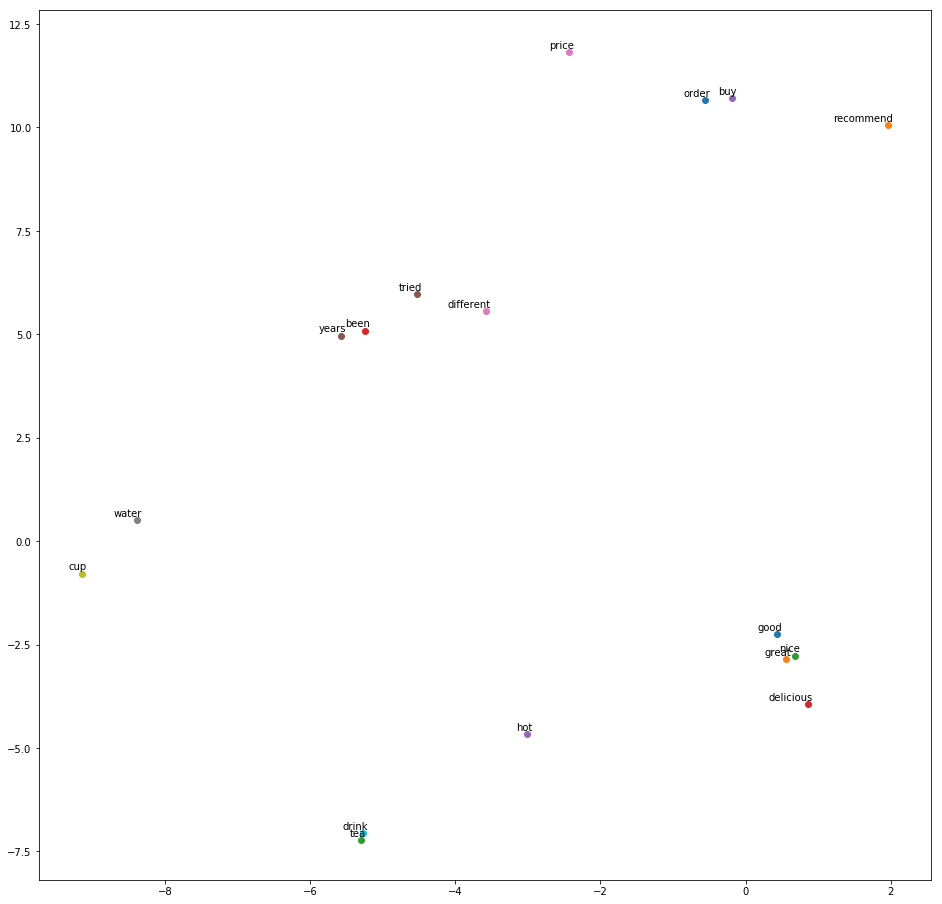

In [24]:
tsne_plot(sg_model)

You can see that the "years", 'different' and 'been' cluster together signifying probably nostalgia; "recommend", "order", "buy" and "price" are probably the considerations that the customer takes in when ordering the item; "good", "delicious", "great", "nice" are clustered together and "hot", "water", "drink", "tea", "cup" seem to go together when people are thinking about drinks and beverages.